Исследуем следующие особенности задержек рейсов:
1. В какие месяцы рейсы чаще страдают от погодных задержек
2. В какие дни недели наибольшие задержки рейсов
3. В какие часы вылета наибольшая общая задержка рейсов
4. В какие часы вылета наибольшая задержка рейсов из-за опоздания с прошлого рейса
5. Как дистанция маршрута влияет на погодную задержку

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('flights.csv', dtype=str)
nyc_airports = ['JFK', 'LGA', 'EWR']
df = df[df['ORIGIN_AIRPORT'].isin(nyc_airports)]
df.isna().any(axis=0)
df[['DEPARTURE_TIME', 'ARRIVAL_TIME']].isna().any(axis=1)
df = df.loc[~df[['DEPARTURE_TIME', 'ARRIVAL_TIME']].isna().any(axis=1)]
pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
cols = list(df.columns)
df = df[cols[-1:] + cols[:-1]]
df.AIR_TIME = df.AIR_TIME.astype(float)
df['ROUTE'] = df['ORIGIN_AIRPORT'] + df['DESTINATION_AIRPORT']
df = df.loc[(df.ORIGIN_AIRPORT.apply(len) == 3) &
            (df.DESTINATION_AIRPORT.apply(len) == 3)]
df_air = pd.read_csv('airlines.csv')
tmp = df.groupby('AIRLINE')['ROUTE'].nunique().sort_values()[::-1].to_frame().reset_index()
tmp = tmp.rename(columns={'AIRLINE': 'IATA_CODE'})
tmp.merge(df_air, on='IATA_CODE')
df_arp = pd.read_csv('airports.csv')




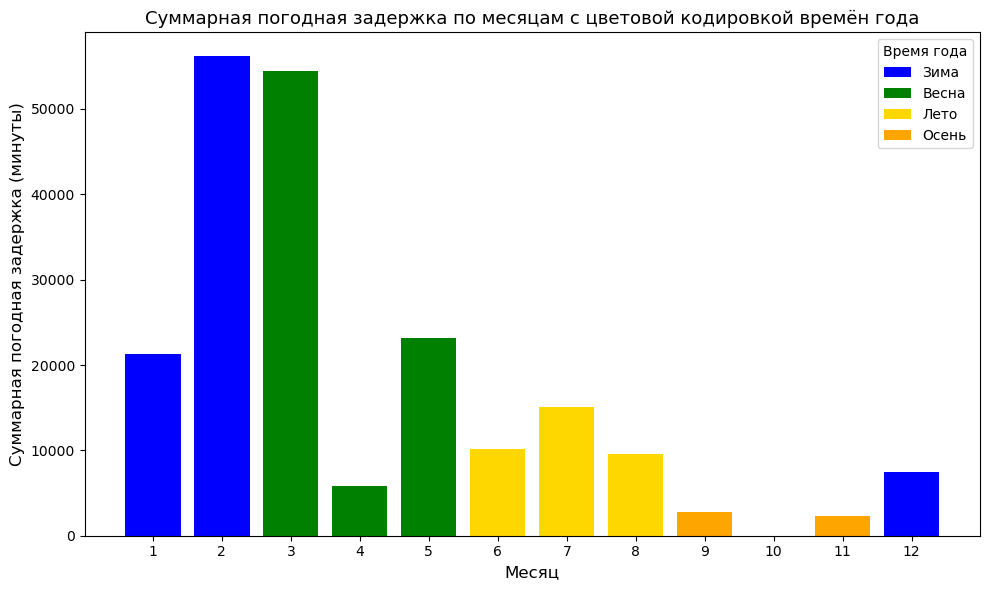

In [3]:
df['MONTH'] = pd.to_numeric(df['MONTH'], errors='coerce')
df['WEATHER_DELAY'] = pd.to_numeric(df['WEATHER_DELAY'], errors='coerce')
weather_delay_by_month = df.groupby('MONTH')['WEATHER_DELAY'].sum()
weather_delay_by_month = weather_delay_by_month.reindex(range(1, 13), fill_value=0)
season_colors = {
    1: 'blue',  
    2: 'blue',  
    3: 'green', 
    4: 'green',
    5: 'green',
    6: 'gold',  
    7: 'gold',
    8: 'gold',
    9: 'orange',  
    10: 'orange',
    11: 'orange',
    12: 'blue'  
}
colors = [season_colors[month] for month in range(1, 13)]
plt.figure(figsize=(10, 6))
bars = plt.bar(
    weather_delay_by_month.index,
    weather_delay_by_month.values,
    color=colors
)
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Суммарная погодная задержка (минуты)', fontsize=12)
plt.title('Суммарная погодная задержка по месяцам с цветовой кодировкой времён года', fontsize=13)
plt.xticks(range(1, 13))
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='blue', label='Зима'),
    Patch(facecolor='green', label='Весна'),
    Patch(facecolor='gold', label='Лето'),
    Patch(facecolor='orange', label='Осень')
]
plt.legend(handles=legend_elements, title='Время года')
plt.tight_layout()
plt.show()

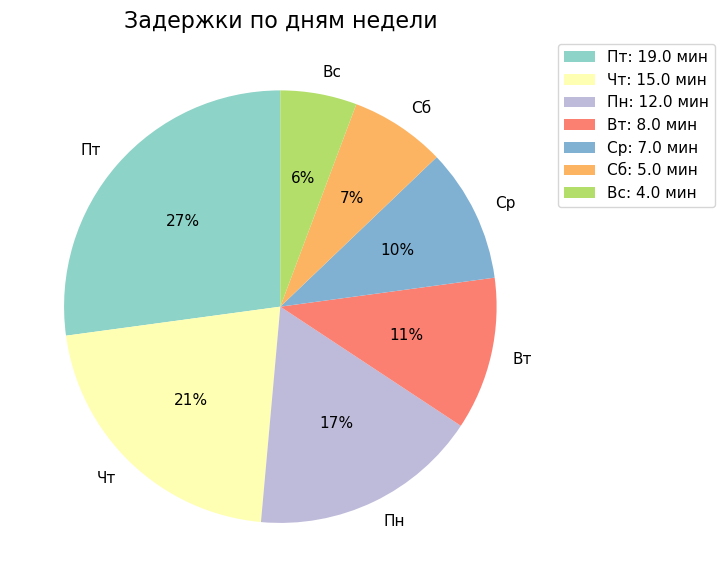

In [267]:
df = pd.DataFrame({
    'DAY_OF_WEEK': [1,2,3,4,5,6,7]*10,
    'ARRIVAL_DELAY': [12,8,7,15,19,5,4]*10
})
d = df.groupby('DAY_OF_WEEK')['ARRIVAL_DELAY'].mean().sort_values(ascending=False)
days = ['Пн','Вт','Ср','Чт','Пт','Сб','Вс']
labels = [days[int(i)-1] for i in d.index]

plt.figure(figsize=(8,6))
plt.pie(d, labels=labels, autopct='%1.0f%%', startangle=90, colors=plt.cm.Set3.colors)
plt.title('Задержки по дням недели', size=16)
plt.legend([f'{l}: {v:.1f} мин' for l,v in zip(labels,d)], loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

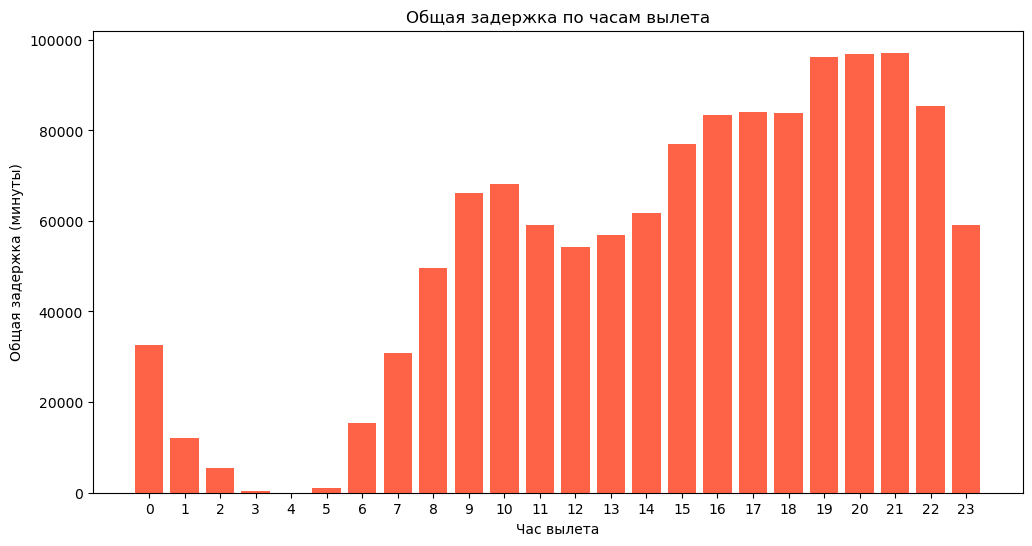

In [20]:
df['AIRLINE_DELAY'] = pd.to_numeric(df['AIRLINE_DELAY'], errors='coerce')
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].astype(str).str.zfill(4)
df['HOUR'] = pd.to_numeric(df['DEPARTURE_TIME'].str[:2], errors='coerce').fillna(0).astype(int)
df['HOUR'] = df['HOUR'].clip(0, 23)
delays_by_hour = df.groupby('HOUR')['AIRLINE_DELAY'].sum()
delays_by_hour = delays_by_hour.reindex(range(24), fill_value=0)
plt.figure(figsize=(12, 6), dpi=100)
plt.bar(delays_by_hour.index.astype(str), delays_by_hour.values, color='tomato')
plt.xlabel('Час вылета')
plt.ylabel('Общая задержка (минуты)')
plt.title('Общая задержка по часам вылета')
plt.xticks(range(24))
plt.show()

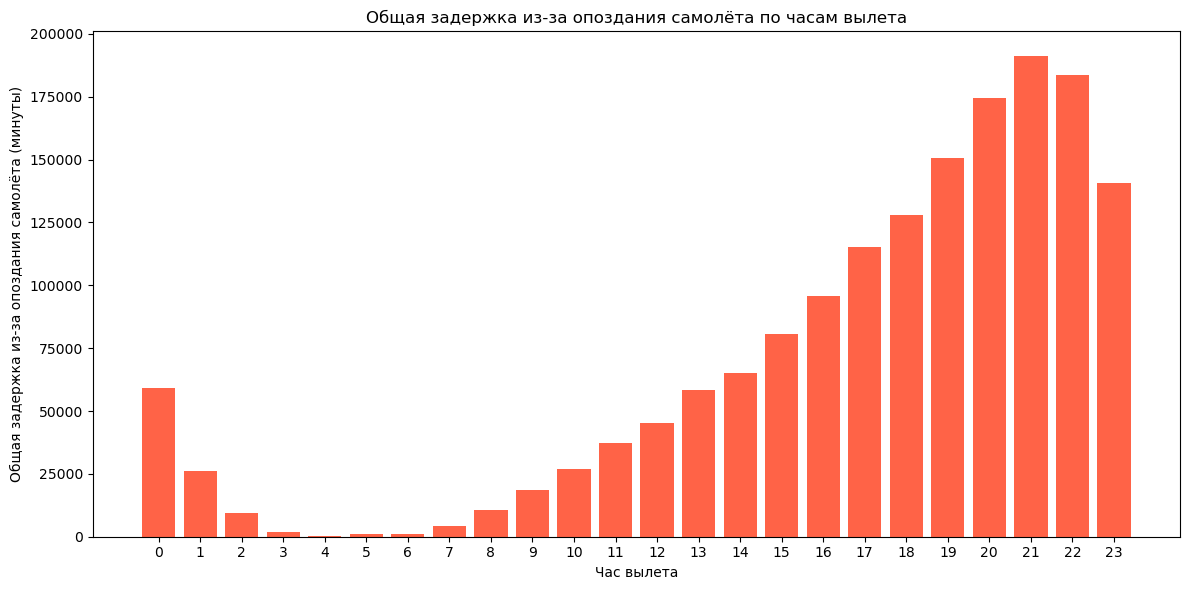

In [22]:
df['LATE_AIRCRAFT_DELAY'] = pd.to_numeric(df['LATE_AIRCRAFT_DELAY'], errors='coerce')
delay_by_hour = df.groupby('HOUR')['LATE_AIRCRAFT_DELAY'].sum()
delay_by_hour = delay_by_hour.reindex(range(24), fill_value=0)  
plt.figure(figsize=(12, 6))
plt.bar(delay_by_hour.index.astype(str), delay_by_hour.values, color='tomato')
plt.xlabel('Час вылета')
plt.ylabel('Общая задержка из-за опоздания самолёта (минуты)')
plt.title('Общая задержка из-за опоздания самолёта по часам вылета')
plt.tight_layout()
plt.show()

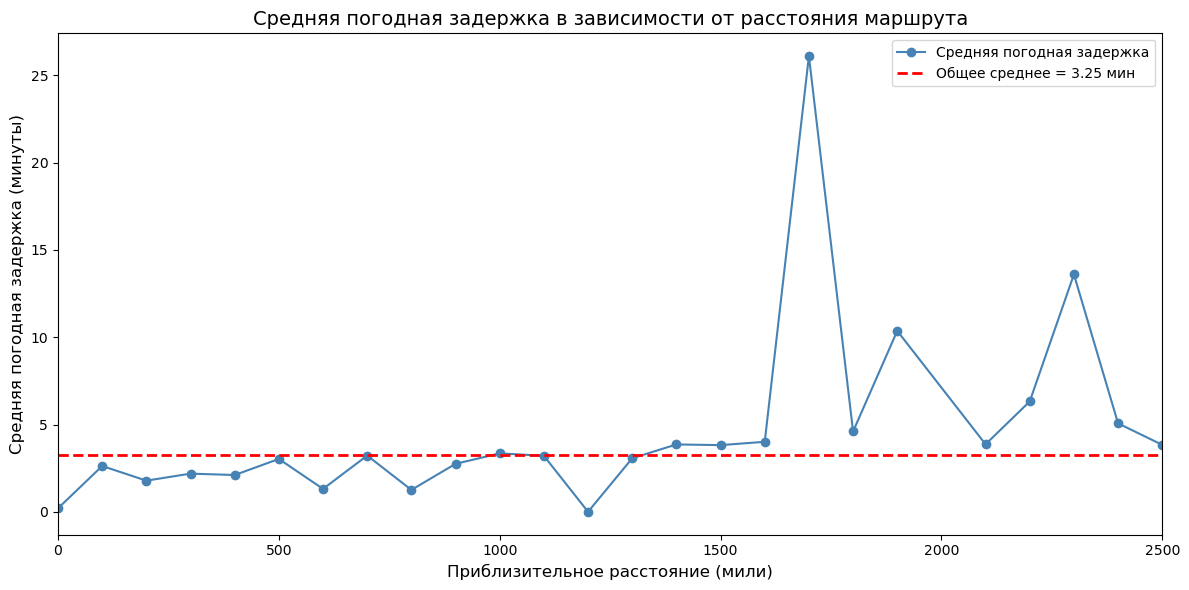

In [17]:
df['WEATHER_DELAY'] = pd.to_numeric(df['WEATHER_DELAY'], errors='coerce')
df['APPROXIMATE_DISTANCE'] = (df['DISTANCE'].astype(int) // 100) * 100
avg_weather_delay_by_dist = df.groupby('APPROXIMATE_DISTANCE')['WEATHER_DELAY'].mean()
overall_mean = df['WEATHER_DELAY'].mean()
plt.figure(figsize=(12, 6))
plt.plot(avg_weather_delay_by_dist.index, avg_weather_delay_by_dist.values, 
         marker='o', linestyle='-', color='steelblue', label='Средняя погодная задержка')
plt.axhline(y=overall_mean, color='red', linestyle='--', linewidth=2, 
            label=f'Общее среднее = {overall_mean:.2f} мин')
plt.xlim(0, 2500)  #мало значений больше 2500, поэтому ограничим
plt.xlabel('Приблизительное расстояние (мили)', fontsize=12)
plt.ylabel('Средняя погодная задержка (минуты)', fontsize=12)
plt.title('Средняя погодная задержка в зависимости от расстояния маршрута', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

Приходим к следующим выводам:
1. Наибольшие погодные задержки наблюдаются зимой и весной (особенно в феврале и марте)
2. Наибольшие задержки рейсов наблюдаются в начале (понедельник) и конце (четверг, пятница) рабочей недели
3. Общая задержка возрастает с 4 часов практически монотонно, достигая максимума в 20-21 час, после чего идёт на спад
4. Общая задержка возрастает с 4 часов монотонно, достигая максимума в 21 час, после чего идёт на спад
5. Погодная задержка при полётах длиной менее 1500 миль в среднем колеблется около среднего значения (3.25 минут), не превышая ее, а при полетах длинее в среднем превышает её, причём иногда в несколько раз